In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = "./data"

In [5]:
orders = pd.read_csv(f"{DATA_DIR}/orders.csv")
order_prior = pd.read_csv(f"{DATA_DIR}/order_products__prior.csv")
order_train = pd.read_csv(f"{DATA_DIR}/order_products__train.csv")
products = pd.read_csv(f"{DATA_DIR}/products.csv")
aisles = pd.read_csv(f"{DATA_DIR}/aisles.csv")
departments = pd.read_csv(f"{DATA_DIR}/departments.csv")

# Combine prior + train to get the complete order-item details
order_products = pd.concat([order_prior, order_train], axis=0, ignore_index=True)

print("orders shape:", orders.shape)
print("order_products shape:", order_products.shape)
print("products shape:", products.shape)
print("aisles shape:", aisles.shape)
print("departments shape:", departments.shape)

orders.head() #the first 5 rows are displayed, all orders from the first user

orders shape: (3421083, 7)
order_products shape: (33819106, 4)
products shape: (49688, 4)
aisles shape: (134, 2)
departments shape: (21, 2)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
# Missing values in days_since_prior_order: The first order is NaN, fill it with 0 (indicating "no previous order")
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0)

# Merge the product tables and attach aisle/department/product name to each product_id
products_full = (
    products
    .merge(aisles, on="aisle_id", how="left")
    .merge(departments, on="department_id", how="left")
)

products_full.head()


,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


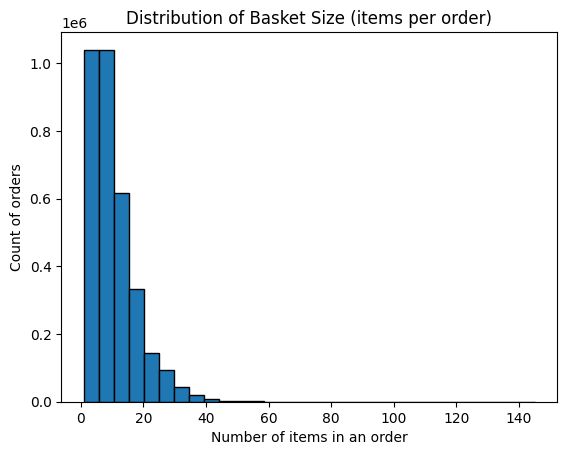

In [8]:
# Count how many items each order contains
basket_size_per_order = (
    order_products
    .groupby("order_id")["product_id"]
    .count()
    .rename("basket_size")
    .reset_index()
)

basket_size_per_order.head()

plt.hist(basket_size_per_order["basket_size"], bins=30, edgecolor='black')
plt.title("Distribution of Basket Size (items per order)")
plt.xlabel("Number of items in an order")
plt.ylabel("Count of orders")
plt.show()


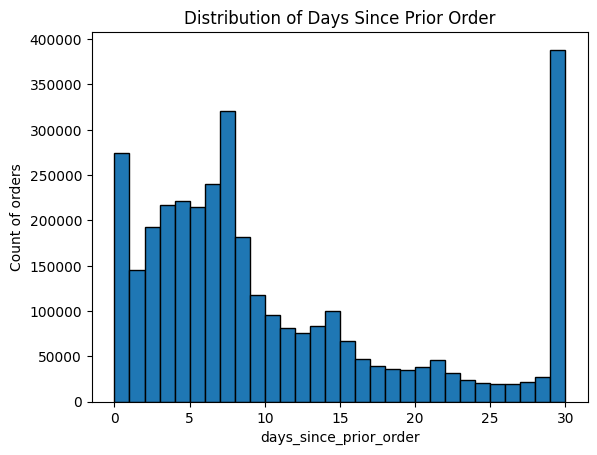

count    3.421083e+06
mean     1.044488e+01
std      9.308727e+00
min      0.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.500000e+01
max      3.000000e+01
Name: days_since_prior_order, dtype: float64

In [9]:
plt.hist(orders["days_since_prior_order"], bins=30, edgecolor='black')
plt.title("Distribution of Days Since Prior Order")
plt.xlabel("days_since_prior_order")
plt.ylabel("Count of orders")
plt.show()

orders["days_since_prior_order"].describe()


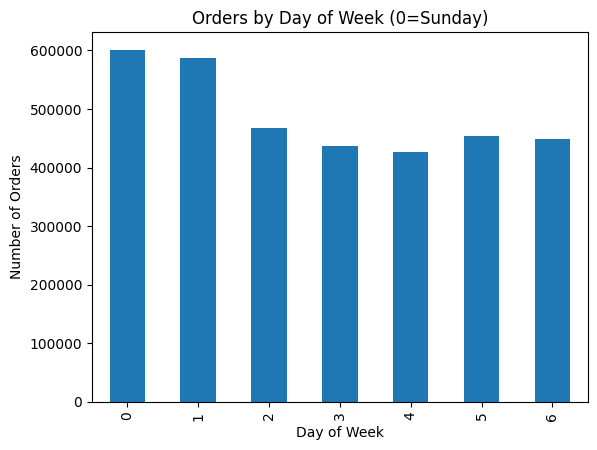

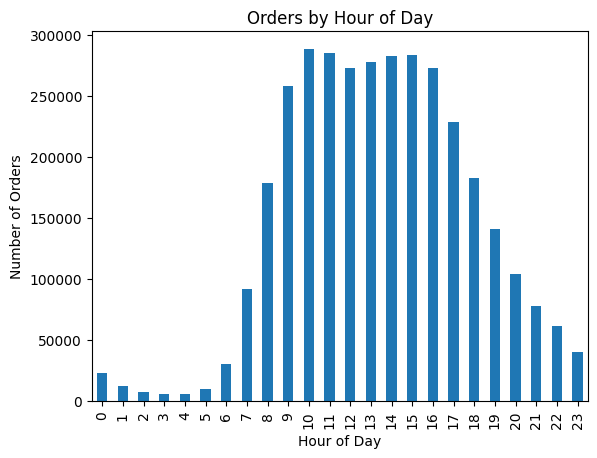

In [10]:
orders["order_dow"].value_counts().sort_index().plot(kind="bar")
plt.title("Orders by Day of Week (0=Sunday)")
plt.xlabel("Day of Week")
plt.ylabel("Number of Orders")
plt.show()

orders["order_hour_of_day"].value_counts().sort_index().plot(kind="bar")
plt.title("Orders by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.show()


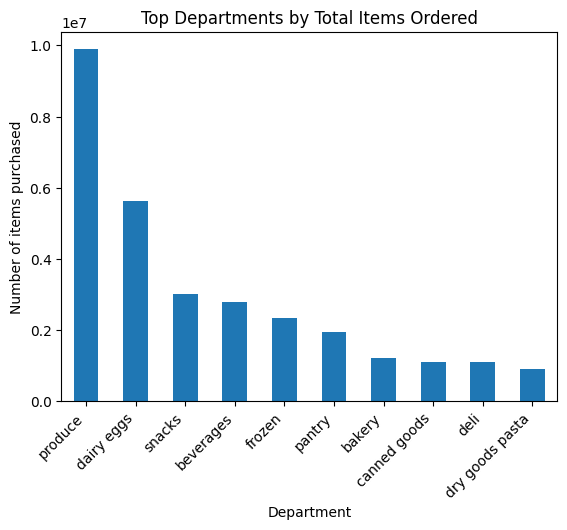

In [18]:
# Merge order_products and products_full to get department/aisle information
order_products_with_user = order_products.merge(
    orders[["order_id", "user_id"]],
    on="order_id",
    how="left"
)

order_products_enriched = order_products_with_user.merge(
    products_full[["product_id", "department", "aisle"]],
    on="product_id",
    how="left"
)

dept_counts = (
    order_products_enriched["department"]
    .value_counts()
    .sort_values(ascending=False)
)

dept_counts.head(10).plot(kind="bar")
plt.title("Top Departments by Total Items Ordered")
plt.xlabel("Department")
plt.ylabel("Number of items purchased")
plt.xticks(rotation=45, ha="right")
plt.show()


Overall reorder rate: 0.5900617242809434


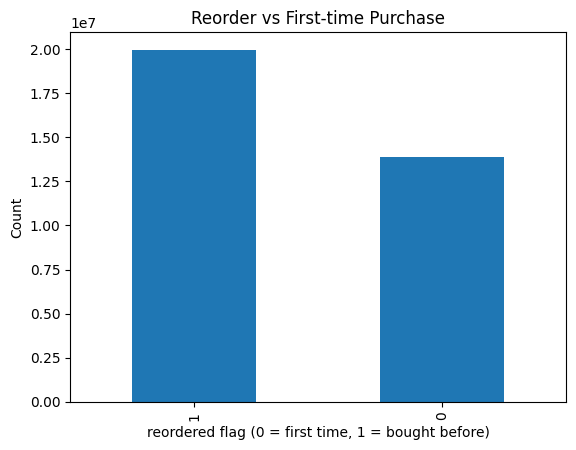

In [19]:
reorder_rate = order_products["reordered"].mean()
print("Overall reorder rate:", reorder_rate)

# Draw the distribution (ratio of 0 vs 1)
order_products["reordered"].value_counts().plot(kind="bar")
plt.title("Reorder vs First-time Purchase")
plt.xlabel("reordered flag (0 = first time, 1 = bought before)")
plt.ylabel("Count")
plt.show()


In [20]:
# Average order interval, total number of orders, average basket size, number of departments purchased
# We have already calculated the basket size per order (basket_size_per_order)
orders_with_basket = orders.merge(basket_size_per_order, on="order_id", how="left")

# Aggregate for each user
user_features = (
    orders_with_basket
    .groupby("user_id")
    .agg(
        avg_days_between_orders = ("days_since_prior_order", "mean"),
        total_orders = ("order_number", "max"),  # 最大 order_number = 下单总次数
        avg_basket_size = ("basket_size", "mean")
    )
    .reset_index()
)

# How many departments each user has purchased
user_departments = (
    order_products_enriched
    .groupby(["user_id"])["department"]
    .nunique()
    .reset_index()
    .rename(columns={"department": "unique_departments"})
)

user_features = user_features.merge(user_departments, on="user_id", how="left")
user_features.head()


,user_id,avg_days_between_orders,total_orders,avg_basket_size,unique_departments
0,1,17.272727,11,6.363636,7
1,2,15.200000,15,15.066667,13
2,3,11.076923,13,7.333333,9
3,4,14.166667,6,3.600000,9
4,5,9.200000,5,9.200000,10
